augmentation기법을 적용해 ResNet-50을 학습시켜 보도록 합니다.

학습내용
1. Augmentation 적용 (1) 데이터 불러오기
2. Augmentation 적용 (2) Augmentation 적용하기
3. Augmentation 적용 (3) 비교 실험하기
4. 심화 기법 (1) Cutmix Augmentation
5. 심화 기법 (2) Mixup Augmentation
6. 프로젝트: CutMix 또는 Mixup 비교실험하기

### 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

사용할 데이터셋은 stanford_dogs. 120개 견종의 이미지가 포함되어 있습니다.총 20580장의 이미지에서 12000장은 학습, 나머지 8580은 평가용 입니다.

데이터를 처음 다운로드 한다면 다운로드 시간이 10분정도로 시간이 오래 걸립니다. 이 데이터셋은 다른 프로젝트에서도 사용할 수 있으니 프로젝트 디렉토리가 아닌 TensorFlow Datasets 기본 디렉토리에 저장합니다.


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


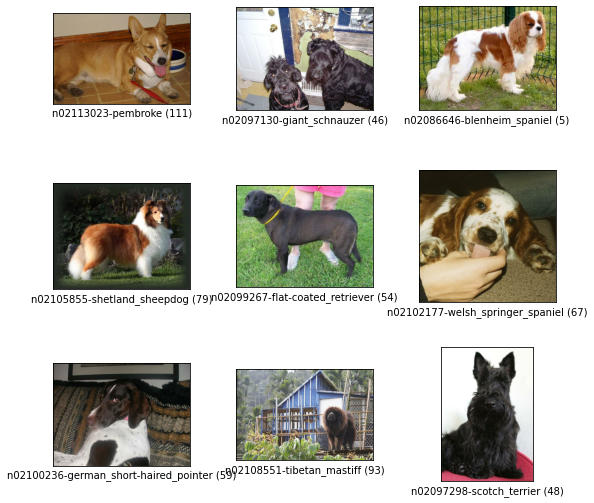

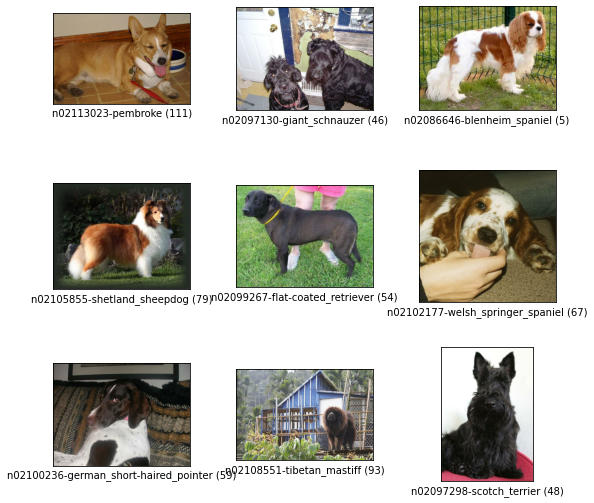

In [4]:
# 데이터 확인
tfds.show_examples(ds_train, ds_info)

### augmentation
많은 augmentation기법들중 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해봅니다.

이미지셋에 대해서 랜덤한 확률로 바로 적용 가능한 augmentation함수는 아래와 같습니다.
- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

augmentation을 하기에 앞서 기본적인 전처리 함수를 먼저 만들어 줍니다.

In [9]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

```
def 전처리_함수(image,label):     # 변환할 이미지와
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label
```
이미지를 변환하는 전처리 함수는 위와 같은 형태를 가지게 됩니다. 이런 형태로 전처리 함수를 만들면 이미지 변환의 결과로 리턴 받은 이미지를 그다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리합니다. 

위 전처리 함수는 입력받은 이미지를 0~1 사이의 float31로 normalize하고, (244,244)로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것 입니다.

random augmentation 중에서 random_flip_left_right()과 random_brightness()를 활용합니다. 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않지만 **상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집힌 사진이 없을것** 이므로 상하 대칭은 도움이 되지 않을것 입니다. 또 brightness를 조절해서 다양한 환경에서 얻어진 이미지에 대응할 수 있게 합니다.

In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


apply_normalize_on_dataset()의 함수에 augmentation을 적용하여 원본 데이터셋에 다양한 가공된 형태의 새로운 데이터셋을 얻게하는것을 구현해 봅니다. 이 함수에서는 normalize,resize,augmentation,shuffle을 적용시킵니다. 단, shuffle이나augmentation은 테스트데이터에 적용하지 않아야 합니다.

여러 결과를 조합하기 위한 앙상블 방법중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있지만 지금은 개념만 알아두고 이번 학습 과정에서는 사용하지 않도록 합니다.

In [11]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug: # with_aug: 추후에 있을 비교실험을 위해 augmentation의 작동여부를 매게변수를 통해 정할수 있게 함
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


다른 tf.image의 함수들을 이용해서 위에서 구현한 random augmentation 함수를 만들수 있습니다.

In [12]:
# make random augment function
def augment2(image,label):
    image = tf.image.random_crop(image, size = (224,224))
    image = tf.image.random_brighness(image, max_delta = 0.5)
    return image, label

### 비교실험
augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능차이를 비교합니다. 텐서플로우 케라스의 ResNet-50중 imagenet으로 훈련된 모델을 불러옵니다. include_top은 마지막 fully connected layer를 포함할지 여부입니다. 이 레이어를 포함하지 않고 생성하면 특성 추출기 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 사용할 수 있습니다. 이렇게 하는 이유는 이미지넷과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [7]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만듭니다.

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aut를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


두 모델에 각각 데이터셋을 학습시키고 검증시킵니다.

In [16]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 363s 450ms/step - loss: 3.1806 - accuracy: 0.2795 - val_loss: 2.9208 - val_accuracy: 0.2833
Epoch 2/20
750/750 [==============================] - 339s 453ms/step - loss: 0.8809 - accuracy: 0.7581 - val_loss: 1.0706 - val_accuracy: 0.6800
Epoch 3/20
750/750 [==============================] - 340s 454ms/step - loss: 0.2810 - accuracy: 0.9420 - val_loss: 0.9839 - val_accuracy: 0.7157
Epoch 4/20
750/750 [==============================] - 340s 454ms/step - loss: 0.0736 - accuracy: 0.9938 - val_loss: 0.9199 - val_accuracy: 0.7346
Epoch 5/20
750/750 [==============================] - 340s 454ms/step - loss: 0.0325 - accuracy: 0.9979 - val_loss: 0.9111 - val_accuracy: 0.7417
Epoch 6/20
750/750 [==============================] - 340s 454ms/step - loss: 0.0168 - accuracy: 0.9998 - val_loss: 0.9367 - val_accuracy: 0.7416
Epoch 7/20
750/750 [==============================] - 340s 454ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.9356 -

훈련 과정을 시각화 해봅니다

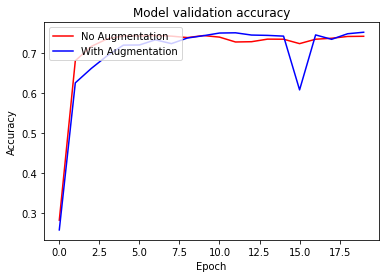

In [17]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

조금 더 확대해서 봅니다

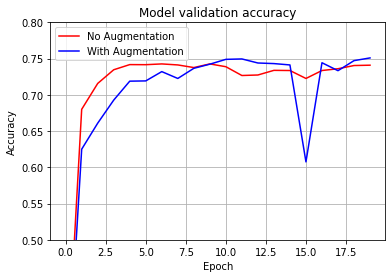

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

중간에 한번 큰폭으로 accuracy가 낮아지기는 하지만 결과적으로 augmentation을 한 데이터셋을 사용한 모델이 더 좋은 성능을 보여줬습니다.

### Cutmix Augmentation
네이버 클로바에서 발표한 Cutmix:Regularization Strategy to Train Strong Classifier with Localizable Features에서 제안된 방법입니다.

**Mixup**은 특정 비율로 픽셀별 값을 섞는 방식이고, **Cutout**은 이미지를 잘라내는 방식입니다. **CutMix**는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법입니다.

**CutMix**는 (1)이미지를 섞는 부분과 (2)섞은 이미지에 맞추어 라벨을 섞는 부분을 포함합니다.

![cutmix.PNG](cutmix.PNG)

### (1)이미지 섞기
가장 먼저 두 이미지를 섞습니다. 배치 내의 이미지를 두 개 골라서 섞어줍니다. 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스라고 부릅니다. 예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 봅니다.

이미지 섞는 부분에서 해야 할 것은:
1. 바운딩 박스의 위치를 랜덤하게 뽑는다.
2. 뽑은 바운딩 박스를 잘라내서 두 개의 이미지를 섞는 함수를 만든다.
3. 이미지를 텐서로 만들어 텐서플로우 연산을 사용하는데, 이때 이미지는 tfds에서 한 장을 뽑아서 사용한다.

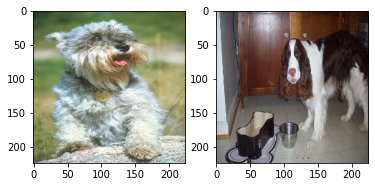

In [14]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

이 중 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 구현합니다.

이번 노드에서 이미지 a,b가 모두 (244,244)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 repo에서는 width,height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 사이즈에 대해서도 유연하게 대응 가능하게 구현해봅니다.

In [15]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(19, shape=(), dtype=int32) tf.Tensor(47, shape=(), dtype=int32)
y :  tf.Tensor(123, shape=(), dtype=int32) tf.Tensor(203, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현합니다.

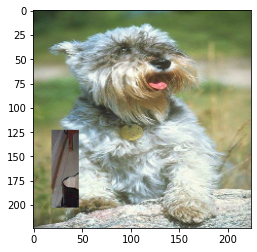

In [16]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### (2) 라벨 섞기
이미지를 섞었다면 라벨도 이에 맞게 섞어줘야 합니다. 

CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다. 예를 들어 A 클래스를 가진 원래 이미지 image_a와 b클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다. 이때 라벨 벡터는 보통 글래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현합니다.

In [17]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.95535713, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04464286, 0.        , 0.        , 0.        ,
       0.     

위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현합니다.

In [18]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### Mixup Augmentation
Mixup은 두 개의 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 더 간단합니다.

두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

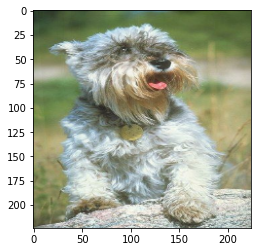

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.9579332
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.04206681 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

In [19]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현합니다.

In [20]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# 프로젝트: CutMix 또는 Mixup 비교실험 하기

### 1. Augmentation을 적용한 데이터셋 만들기

※CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.※


In [21]:
def onehot(image, label):
    num_classes = 120
#     onehot_label = [0]*num_classes
    onehot_label = tf.one_hot(label, num_classes)
#     onehot_label[label] = 1
# tf.reshape(tf.stack(onehot_label), (1920,))
    return image, onehot_label

In [22]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not with_cutmix and not with_mixup:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


### 2. 모델 만들기

In [23]:
# without
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [24]:
# standard
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [25]:
# cutmix
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
# mixup
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [28]:
EPOCH = 20


resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
resnet50.summary()

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
aug_resnet50.summary()

print('no_aug 학습 시작')
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('no_aug 학습 끝')

print('aug 학습 시작')
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('aug 학습 끝')

tf.random.set_seed(2020)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)
cutmix_resnet50.summary()

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
mixup_resnet50.summary()

print('cutmix 학습 시작')
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('cutmix 학습 종료')

print('mixup 학습 시작')
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
print('mixup 학습 종료')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
________________________________________________________________

sparse_categorical_crossentropy()를 사용하지 못하는 이유:


우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문입니다.

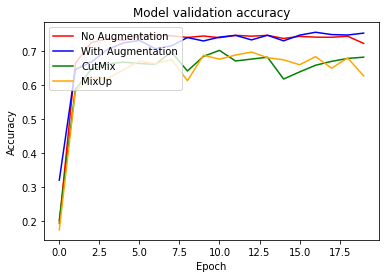

In [29]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'green')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.show()

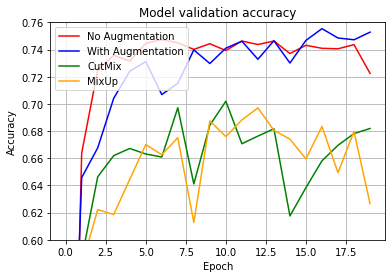

In [30]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'green')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)
plt.show()


### 성능비교
기대했던 cutmix와 mixup의 성능이 그다지 좋지 못함을 확인했습니다. 이정도의 성능이라면 차라리 사용하지 않는것이 좋아보입니다. 기본 tf가 제공하는 augmentation의 절반수준에 그치는걸 보면 다른 대안을 찾아봐야 할거 같습니다. cutmix와 mixup이 성능을 제대로 못내는 이유로 추측하자면 가령 stanford 강아지 데이터셋을 예로 들자면, 두 강아지의 사진이 합쳐질때 어느정도 강아지의 모양이 있어야 모델이 강아지로써 학습이 가능하지만, 여러 각도 혹은 사이즈의 데이터를 무작위로 합친다면 강아지의 형상이 나타나기가 힘들어 모델이 강아지로써 인식을 하지 못해서 이런 성능이 나온거 같습니다. 대안으로써 비슷한 각도 혹은 사이즈의 사진들만 따로 모아 합쳐서 augmentation을 진행하면 좀 나아질거라고 생각합니다.